Instalacion de Yolo 10 :

En una terminal <br>
git clone https://github.com/THU-MIG/yolov10.git <br>
cd yolov10 <br>
pip install . 

In [1]:
from ultralytics import YOLO
import pytesseract
import cv2
import supervision as sv
from supervision.draw.color import ColorPalette
from supervision.detection.annotate import BoxAnnotator
import numpy as np

In [2]:
# funcion que recorta imagenes
def cropped(detections,image):
    bounding_box = detections.xyxy
    # Extraer las coordenadas de la caja delimitadora
    xmin, ymin, xmax, ymax = bounding_box[0]
    # Asegurarse de que las coordenadas sean enteros
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    # Recortar la imagen usando las coordenadas de la caja delimitadora
    cropped_image = image[ymin:ymax, xmin:xmax]
    return cropped_image

### Codigo sobre un frame <br>
El código primero se probara para mayor facilidad sobre un frame y despues se analizara en un video


0: 352x640 1 car, 808.5ms
Speed: 19.0ms preprocess, 808.5ms inference, 42.0ms postprocess per image at shape (1, 3, 352, 640)


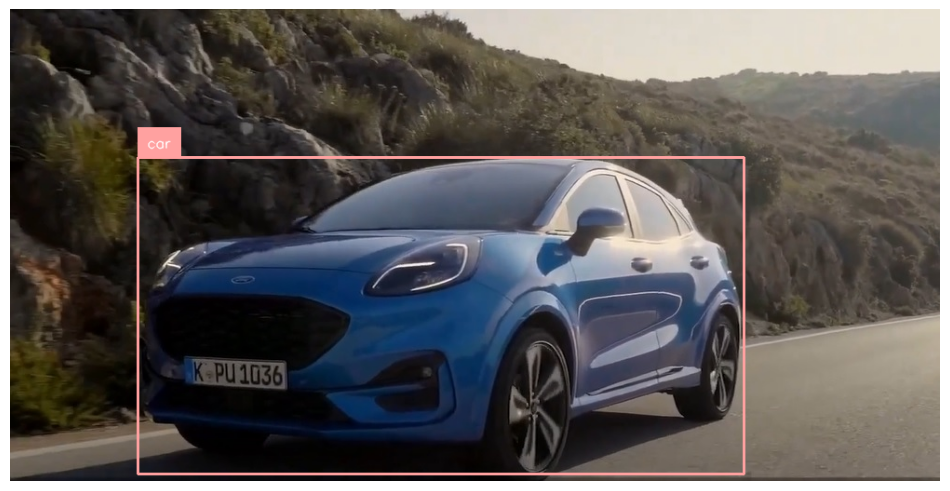

In [3]:
#Deteccion del medio de transporte

#modelo para detectar el medio de transporte
model_t = YOLO('models\yolov10n.pt')

#se lee la imagen de un auto 
image_t = cv2.imread('images/auto.jpg')

#se pasa la imagen por el modelo que detecta el medio de transporte
results_t = model_t(image_t)[0]

#se pasan los resultados a la libreria supervison
detections_t = sv.Detections.from_ultralytics(results_t)

# dict maping class_id to class_name
class_name = model_t.model.names
# class_ids of interest - car, motorcycle, bus and truck
class_id = [2, 3, 5, 7]

#filtra que solo muestre las detecciones de class_id
if detections_t.class_id in class_id:
    #inicializa las etiquetas
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    #Se pasa la informacion que se mostrara en las etiqutes
    annotated_image_t = bounding_box_annotator.annotate(scene=image_t, detections=detections_t)
    annotated_image_t = label_annotator.annotate(scene=annotated_image_t, detections=detections_t)
        
sv.plot_image(annotated_image_t)

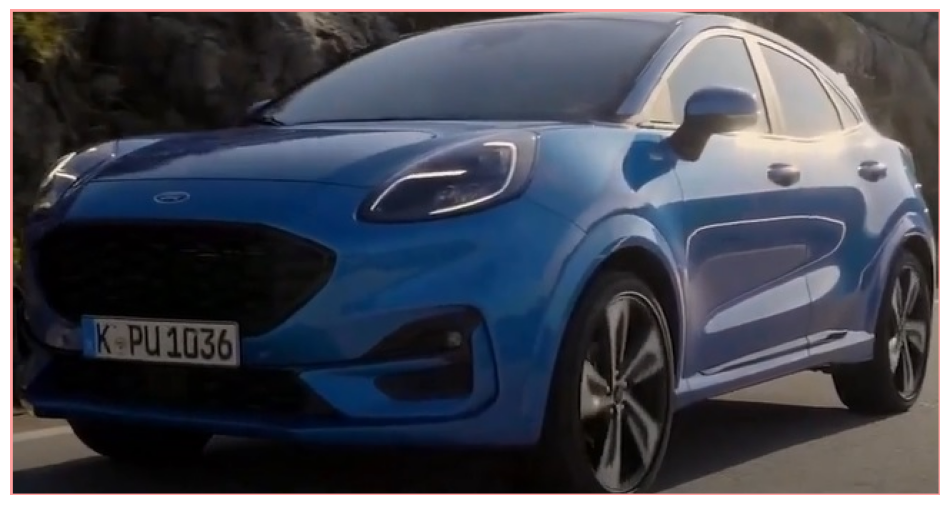

In [4]:
#recorte de imagen de  medio de transporte
cropped_image_t = cropped(detections_t, image_t)
sv.plot_image(cropped_image_t)


0: 352x640 1 pl_license_plate, 308.8ms
Speed: 6.0ms preprocess, 308.8ms inference, 53.0ms postprocess per image at shape (1, 3, 352, 640)


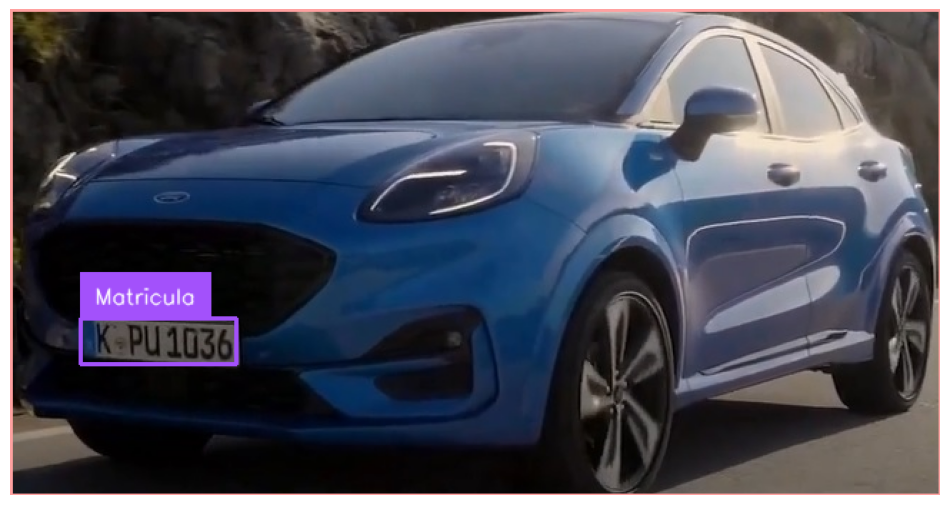

In [5]:
# Deteccion de la placa a a partir de transporte recortado 

#modelo para detectar el medio de matricula
model_p = YOLO('models\placa.pt')
#se pasa la imagen por el modelo que detecta matriculas
results_p = model_p(cropped_image_t, agnostic_nms = True)[0]
#modifica a matricula el nombre que trae por defecto el modelo
results_p.names[0] = "Matricula"
#se pasan los resultados a la libreria supervison
detections_p = sv.Detections.from_ultralytics(results_p)
#inicializa las etiquetas de matriculas
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
#Se pasa la informacion que se mostrara en las etiqutes
annotated_image_p = bounding_box_annotator.annotate(scene=cropped_image_t, detections=detections_p)
annotated_image_p = label_annotator.annotate(scene=annotated_image_p, detections=detections_p)

sv.plot_image(annotated_image_p)

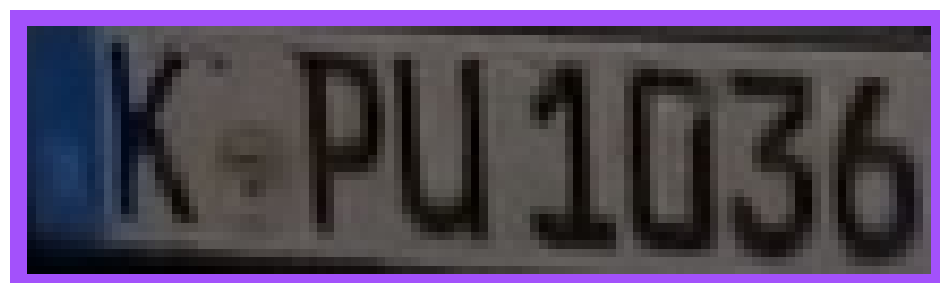

In [6]:
#recorte de imagen de la placa
cropped_image_p = cropped(detections_p, cropped_image_t)

sv.plot_image(cropped_image_p)

IKPU1036



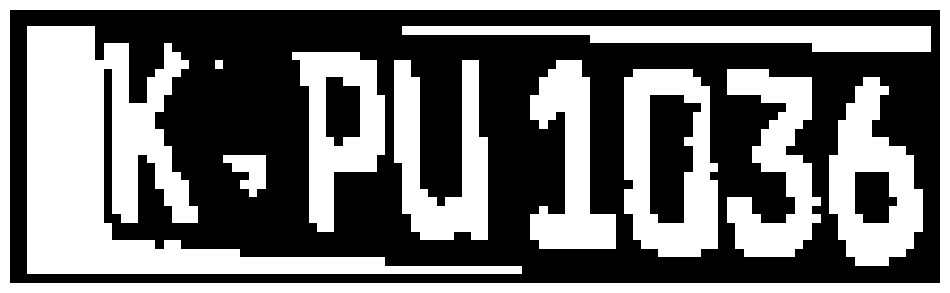

In [7]:
#lectura de la placa con el ocr

# Cargamos la imagen, y la convertimos a escala de grises.
gray = cv2.cvtColor(cropped_image_p, cv2.COLOR_BGR2GRAY)

# Aplicamos thresholding automático con el algoritmo de Otsu. ESto hará que el texto se vea blanco, y los elementos
# del fondo sean menos prominentes.
thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


# Calculamos y normalizamos la transformada de distancia.
dist = cv2.distanceTransform(thresholded, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype('uint8')

# Aplicamos thresholding al resultado de la operación anterior, y mostramos el resultado en pantalla.
dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

#Cambiar directorio donde esta instalado tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

#Pasa el OCR por la imagen en escala de grises y filtra solo numero y letras
data = pytesseract.image_to_string(dist, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYXabcdefghijklmnopqrstuvwxyz')

print(data)

#para anotar la placa y el frame
#annotated_frame = add_text(frame_number, annotated_frame, data)

sv.plot_image(dist)


# Codigo OCR por revisar

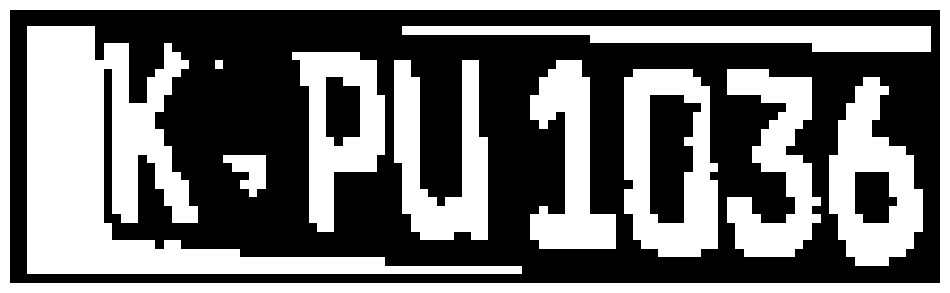

In [8]:
import cv2
import imutils

# Cargamos la imagen, y la convertimos a escala de grises.
gray = cv2.cvtColor(cropped_image_p, cv2.COLOR_BGR2GRAY)

# Aplicamos thresholding automático con el algoritmo de Otsu. ESto hará que el texto se vea blanco, y los elementos
# del fondo sean menos prominentes.
thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Mostramos el resultado parcial en pantalla
sv.plot_image(thresholded)

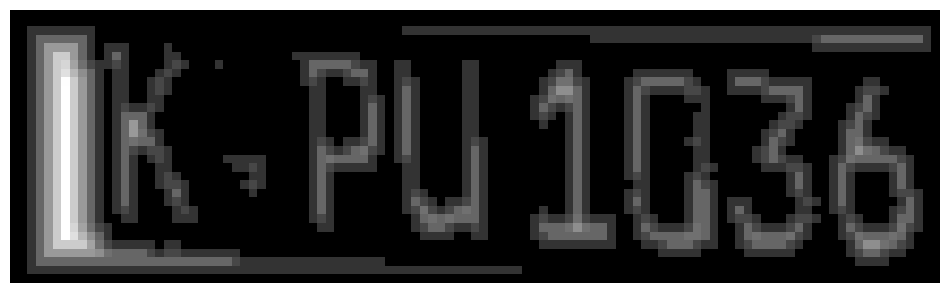

In [9]:
# Calculamos y normalizamos la transformada de distancia.
dist = cv2.distanceTransform(thresholded, cv2.DIST_L2, 5)
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype('uint8')

# Mostramos el resultado parcial en pantalla
sv.plot_image(dist)

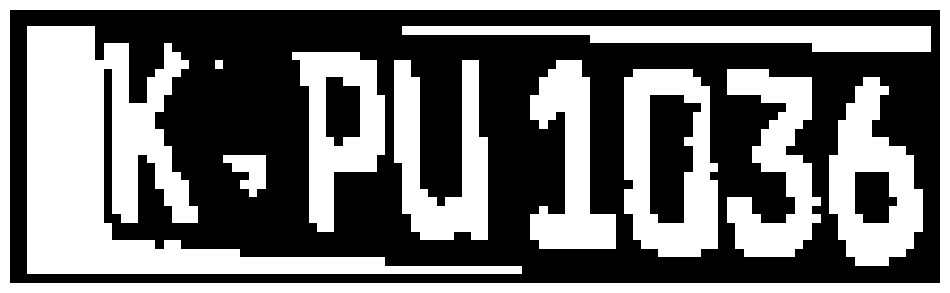

In [10]:
# Aplicamos thresholding al resultado de la operación anterior, y mostramos el resultado en pantalla.
dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Mostramos el resultado parcial en pantalla
sv.plot_image(dist)

IKPU1036



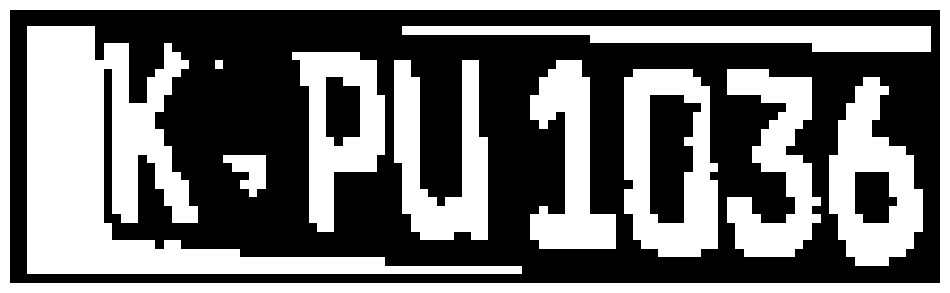

In [11]:
# Extraemos los dígitos de la imagen. Nota el uso de un whitelist de sólo números.
options = '-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYXabcdefghijklmnopqrstuvwxyz'
text = pytesseract.image_to_string(dist, config=options)
print(text)


# Mostramos la imagen resultante de todo el procesamiento.
# Mostramos el resultado parcial en pantalla
sv.plot_image(dist)


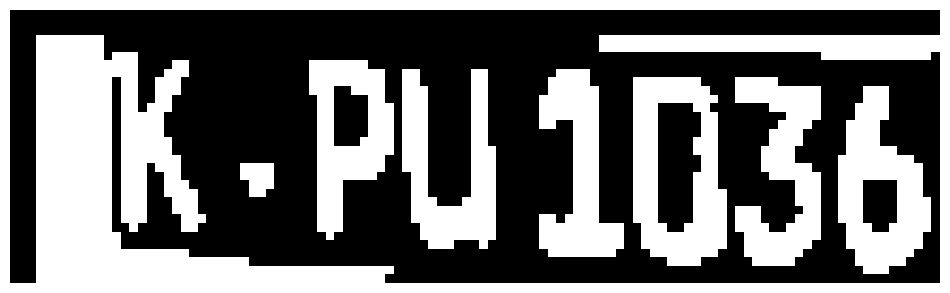

In [12]:
# Aplicamos apertura para desconectar manchas y blobs de los elementos que nos interesan (los números)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel)
# Mostramos el resultado parcial en pantalla
sv.plot_image(opening)

### parte del codigo que ser traba

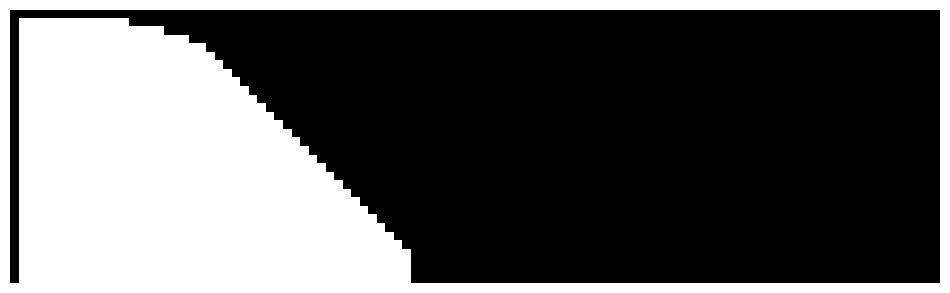

In [13]:
# Hallamos los contornos de los números en la imagen.
contours = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

chars = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Solo los contornos grandes perdurarán, ya que corresponden a los números que nos interesan.
    if w >=10  and h >=25:
        chars.append(contour)

# Hallamos la cáscara convexa que envuelve todos los números.
chars = np.vstack([chars[i] for i in range(0, len(chars))])
hull = cv2.convexHull(chars)

# Creamos una máscara y la alargamos.
mask = np.zeros(cropped_image_p.shape[:2], dtype='uint8')
cv2.drawContours(mask, [hull], -1, 255, -1)
mask = cv2.dilate(mask, None, iterations=2)
# Mostramos el resultado parcial en pantalla
sv.plot_image(mask)        

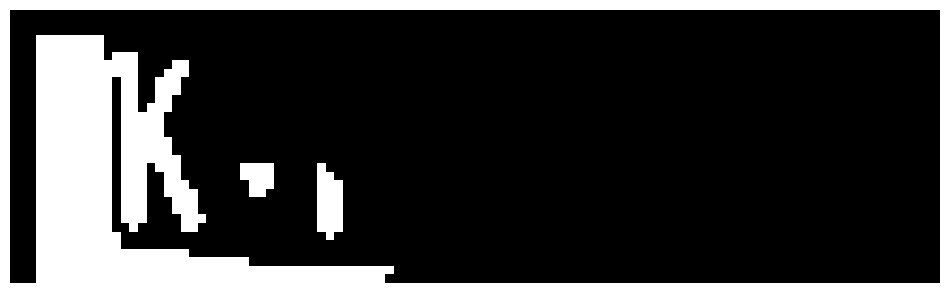

In [14]:
# Aplicamos la máscara para aislar los números del fondo.
final = cv2.bitwise_and(opening, opening, mask=mask)


# Extraemos los dígitos de la imagen. Nota el uso de un whitelist de sólo números.
options = '-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYXabcdefghijklmnopqrstuvwxyz'
text = pytesseract.image_to_string(final, config=options)
print(text)


# Mostramos la imagen resultante de todo el procesamiento.
# Mostramos el resultado parcial en pantalla
sv.plot_image(final)

